In [46]:
import re
import random
import pandas as pd
import hashlib

In [47]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [48]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
WinHex,77.761730,3.702940,11.437039,21
"The Simulacra, Dick",372.454485,19.602868,38.639744,19
Windows PATH Variable,776.542798,25.884760,84.278808,30
Terraform,52.832076,26.416038,28.265166,2
Node.JS and React,1278.660616,41.247117,118.754940,31
Azure Compute Gallery,346.741266,49.534467,87.067445,7
"Mexican Gothic, Moreno-Garcia",1495.361507,53.405768,209.656320,28
Django,2408.773356,60.219334,236.097866,40
Azure Functions Core Tools,1088.625716,64.036807,157.973975,17
Microsoft Purview,2969.934479,65.998544,241.344225,45


# Histogram

sum of ages: ~49983.69


<Axes: >

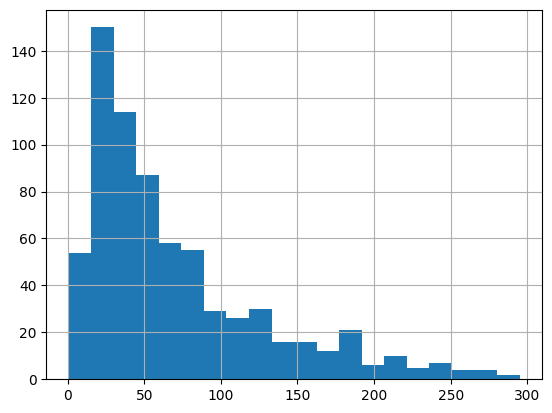

In [49]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~49983.69


<Axes: >

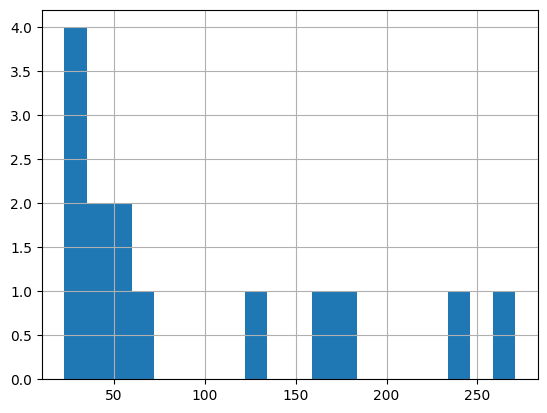

In [50]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Vocab']['age'].hist(bins=20)

# Completely Random Shuffle

In [51]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [52]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [53]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [ ]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

## Age Max

In [55]:
# n = random.choice([2, 3, 3, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [ ]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

floor dividing for n-fold
Cards found: 706
Total card age: 49983.69


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
67,Terraform,Remember that variables can't reference each o...,c938ff1e867840093c794fe980ec1385,28.265166,26.416038,-28.265166,52.832076,0.238374,2,0,0,-28.265166
68,Terraform,You can't nest subnets in Azure! It's embarras...,fcd464f48b593ead6cbb10c437fa16d1,24.566911,26.416038,-28.265166,52.832076,0.238374,2,1,0,-24.566911
58,Azure Compute Gallery,Image Retention Policy – A strategy for keepin...,70c2d698cafb110aac81fc77dbba5e31,87.067445,49.534467,-87.067445,346.741266,0.548178,7,0,0,-87.067445
59,Azure Compute Gallery,Storage Costs for ACG – Storage pricing depend...,f874eec3656a3eb9930b2db2c810055d,86.212361,49.534467,-87.067445,346.741266,0.548178,7,1,0,-86.212361
60,Azure Compute Gallery,Azure DevOps Pipelines for Image Deployment – ...,7f9dc58f909efc213b64a0697735712c,82.618278,49.534467,-87.067445,346.741266,0.548178,7,2,0,-82.618278
136,Azure Compute Gallery,Shared Image Gallery Reader Role – An RBAC rol...,5c68211134057fa344eb09d9183da05a,28.620853,49.534467,-87.067445,346.741266,0.548178,7,3,0,-28.620853
135,Azure Compute Gallery,Replication Time Constraints – Image replicati...,f5615ce9f50e2f668a32d12784e21991,28.312858,49.534467,-87.067445,346.741266,0.548178,7,4,0,-28.312858
37,pfSense,If administrators activate the Netgate Service...,9ba3decdf94cb4ca9473688d9939a003,216.176968,97.682228,-216.176968,879.140052,0.410949,9,0,0,-216.176968
38,pfSense,Bogon networks are those which should never be...,84b9af6a006689a724b51db2d0cb04af,159.681837,97.682228,-216.176968,879.140052,0.410949,9,1,0,-159.681837
39,pfSense,"To check for updates to pfSense software, navi...",438fd54e363098f3194d6e2a852d90ee,157.239773,97.682228,-216.176968,879.140052,0.410949,9,2,0,-157.239773



## Random

In [57]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [58]:
existing_cards.head(10)['age'].sum()

np.float64(898.7624505495498)

In [59]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
1,Terraform Codebox,path.module in Terraform refers to the directo...,0077d1efc41777feb76ac15cfa44de56,294.892151,94.689845,-294.892151,3692.903963,0.785666,39,0,0,-294.892151
4,Active Directory and Azure Files,Kerberos Key (Storage Account key)\nA secret (...,7c008b725311d3b542f19e49340e719d,286.524526,86.497071,-286.524526,3113.894547,0.949667,36,0,0,-286.524526
7,Python + Oauth2.0,http.server.SimpleHTTPRequestHandler\n\nA buil...,142b6319783bfbbf45e56e053e9a4c0c,279.006407,100.400818,-279.006407,2108.417170,0.813620,21,0,0,-279.006407
8,Python + Oauth2.0,redirect_uri\n\nThe URL where the OAuth provid...,0f71673850ec4ac81e9d1d446c5f48a9,275.424883,100.400818,-279.006407,2108.417170,0.813620,21,1,0,-275.424883
10,Node.js and Vite,vite.config.js\nVite’s main configuration file...,6579af3b0c080942dce68776aa2d8914,274.047614,74.982933,-274.047614,3074.300234,0.512915,41,0,0,-274.047614
13,Vocab,"Jingo, Pratchett\nCruet\nnoun | KROO-it\nA sma...",528220646783dfd409ce4f2edf53a104,270.831401,94.903801,-270.831401,1328.653217,0.840129,14,0,0,-270.831401
16,Asynchronous Python,return_exceptions=True (in gather)\nA paramete...,7b43de3dee4f46aa5adbf4020aff8165,262.608875,99.341966,-262.608875,1688.813429,0.891485,17,0,0,-262.608875
2,Terraform Codebox,Terraform allows you to target specific parts ...,93c4df9dde5484c019ce7758b6524728,261.899794,94.689845,-294.892151,3692.903963,0.785666,39,1,0,-261.899794
3,Terraform Codebox,TF_LOG=DEBUG is an environment variable that m...,eb9c36cb0f05a2fd3b6125a9e1fbbab7,260.430142,94.689845,-294.892151,3692.903963,0.785666,39,2,0,-260.430142
19,Azure Files Documentation,Quota is a limit on the size of the file share...,3bef1cf2ec625defd17ff26244de22f9,251.851334,69.723603,-251.851334,3974.245357,0.491833,57,0,0,-251.851334


In [60]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 70.798'